# **Phishing-Website Detection Using Machine Learning Algorithms**


**Project by :** *Narra SuryaKoushik Reddy*

**E-mail :** *narrasuryakoushikreddy@gmail.com*

**Project for :** *Mini project for Data Science in JNTU Hyderabad*

## 1. Installing & Importing Useful libraries

There will be some libraries which are not preinstall, we need to install them manually inorder to run this program

In [29]:
!pip install selenium

In [30]:
!pip install wordcloud

In [31]:
import pandas as pd
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
import plotly.express as px
import time 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline 

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from bs4 import BeautifulSoup 
from selenium import webdriver  
import networkx as nx 
import pickle

import warnings
warnings.filterwarnings('ignore')

## 2. Loading and Analysing the Dataset

In [32]:
# Lading the data set
data_OG = pd.read_csv('phishing_site_urls.csv')

In [86]:
print("First 5 columns of the data")
print(data_OG.head())
print('-'*70)
print("Last 5 columns of the data")
print(data_OG.tail())

First 5 columns of the data
                                                 URL Label  \
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad   
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad   
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad   
3  mail.printakid.com/www.online.americanexpress....   bad   
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad   

                                      text_tokenized  \
0  [nobell, it, ffb, d, dca, cce, f, login, SkyPe...   
1  [www, dghjdgf, com, paypal, co, uk, cycgi, bin...   
2  [serviciosbys, com, paypal, cgi, bin, get, int...   
3  [mail, printakid, com, www, online, americanex...   
4  [thewhiskeydregs, com, wp, content, themes, wi...   

                                        text_stemmed  \
0  [nobel, it, ffb, d, dca, cce, f, login, skype,...   
1  [www, dghjdgf, com, paypal, co, uk, cycgi, bin...   
2  [serviciosbi, com, paypal, cgi, bin, get, into...   
3  [mail, printakid, com, www, onlin, 

In [34]:
# Information of the Dataset
print(data_OG.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB
None


In [35]:
# Checking for missiong values
print(data_OG.isnull().sum())

URL      0
Label    0
dtype: int64


Let's check to determine if the classes are balanced or imbalanced if there are classification issues.

In [36]:
# Class count dataframe
label_counts = pd.DataFrame(data_OG.Label.value_counts())

In [37]:
#visualizing target_col
fig = px.bar(label_counts, x=label_counts.index, y=label_counts.Label)
fig.show()

## 3. Preprocessing 

As soon as we obtain the information, we must vectorize our URLs. Since some terms in urls, such as "virus," ".exe," and ".dat," are more essential than others, I utilised CountVectorizer and gathered words using tokenizer. Let's create a vector form using the URLs.

### 3.1 RegexpTokenizer

A tokenizer that divides a text into tokens and separators by using a regular expression that matches both.

In [38]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')#getting alpha only

In [39]:
data_OG.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [40]:
# pull letter which matches to expression
tokenizer.tokenize(data_OG.URL[0]) # using first row

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [41]:
print('Getting words tokenized ...')
t0= time.perf_counter()
data_OG['text_tokenized'] = data_OG.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 2.7233807000002344 sec


In [42]:
data_OG.sample(5)

,URL,Label,text_tokenized
202877,jeopardyfinalcategory.com/,good,"[jeopardyfinalcategory, com]"
295317,briankeene.com/?p=2385,good,"[briankeene, com, p]"
250553,tvbythenumbers.zap2it.com/2011/09/08/wednesday...,good,"[tvbythenumbers, zap, it, com, wednesday, fina..."
454211,twincochina.com/,good,"[twincochina, com]"
119446,torahacademymil.org/spero/full/proposal/LoginV...,bad,"[torahacademymil, org, spero, full, proposal, ..."


### 3.2 SnowballStemmer

A simple string processing language called Snowball provides root words.

In [43]:
stemmer = SnowballStemmer("english")

In [44]:
print('Getting words stemmed ...')
t0= time.perf_counter()
data_OG['text_stemmed'] = data_OG['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 30.821235099999285 sec


In [45]:
data_OG.sample(5)

,URL,Label,text_tokenized,text_stemmed
209344,lokeshwedsbrahminiwallpapers.blogspot.com/,good,"[lokeshwedsbrahminiwallpapers, blogspot, com]","[lokeshwedsbrahminiwallpap, blogspot, com]"
438028,sprint.com/index_p.html,good,"[sprint, com, index, p, html]","[sprint, com, index, p, html]"
380156,lyngsat-address.com/ln/Nuevo-Mundo-Television....,good,"[lyngsat, address, com, ln, Nuevo, Mundo, Tele...","[lyngsat, address, com, ln, nuevo, mundo, tele..."
149050,bhsinmemoriam.blogspot.com/2010_05_01_archive....,good,"[bhsinmemoriam, blogspot, com, archive, html]","[bhsinmemoriam, blogspot, com, archiv, html]"
243268,stepintohistory.com/states/MO/Missouri_1855.htm,good,"[stepintohistory, com, states, MO, Missouri, htm]","[stepintohistori, com, state, mo, missouri, htm]"


In [46]:
print('Getting joiningwords ...')
t0= time.perf_counter()
data_OG['text_sent'] = data_OG['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.22107529999993858 sec


In [47]:
data_OG.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
535414,moyobamba.com/e5h0wg,bad,"[moyobamba, com, e, h, wg]","[moyobamba, com, e, h, wg]",moyobamba com e h wg
5061,www.frenchtrotters.fr/onlineshop/login.php?lan...,bad,"[www, frenchtrotters, fr, onlineshop, login, p...","[www, frenchtrott, fr, onlineshop, login, php,...",www frenchtrott fr onlineshop login php langua...
105631,chuntaacacademy.edu.bd/dropbox/domain/,bad,"[chuntaacacademy, edu, bd, dropbox, domain]","[chuntaacacademi, edu, bd, dropbox, domain]",chuntaacacademi edu bd dropbox domain
126982,iieac-africa.org/IIFCA.eventum/templates/beez3...,bad,"[iieac, africa, org, IIFCA, eventum, templates...","[iieac, africa, org, iifca, eventum, templat, ...",iieac africa org iifca eventum templat beez co...
383941,manta.com/c/mtv9ft2/stoneriver-inc,good,"[manta, com, c, mtv, ft, stoneriver, inc]","[manta, com, c, mtv, ft, stoneriv, inc]",manta com c mtv ft stoneriv inc


# 4. Visualization

Use a word cloud to visualise certain crucial keys.

In [48]:
#sliceing classes
bad_sites = data_OG[data_OG.Label == 'bad']
good_sites = data_OG[data_OG.Label == 'good']

In [85]:
print("First 5 columns of bad_sites")
print(bad_sites.head())
print('-'*70)
print("First 5 columns of good sites")
print(good_sites.tail())

First 5 columns of bad_sites
                                                 URL Label  \
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad   
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad   
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad   
3  mail.printakid.com/www.online.americanexpress....   bad   
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad   

                                      text_tokenized  \
0  [nobell, it, ffb, d, dca, cce, f, login, SkyPe...   
1  [www, dghjdgf, com, paypal, co, uk, cycgi, bin...   
2  [serviciosbys, com, paypal, cgi, bin, get, int...   
3  [mail, printakid, com, www, online, americanex...   
4  [thewhiskeydregs, com, wp, content, themes, wi...   

                                        text_stemmed  \
0  [nobel, it, ffb, d, dca, cce, f, login, skype,...   
1  [www, dghjdgf, com, paypal, co, uk, cycgi, bin...   
2  [serviciosbi, com, paypal, cgi, bin, get, into...   
3  [mail, printakid, com, www, onlin,

- make a function that displays the key elements from the url

In [50]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '../input/masks/masks-wordclouds/'

In [51]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [52]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

# 5. Creating models 

### 5.1 CountVectorizer

- A corpus of text is converted into a vector of term/token counts using the CountVectorizer.

In [53]:
#Create object
cv = CountVectorizer()

In [54]:
help(CountVectorizer())

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts.
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----

In [55]:
#transforming all text which we tokenize and stemed
feature = cv.fit_transform(data_OG.text_sent)

In [56]:
# convert sparse matrix into array to print transformed features
feature[:5].toarray() 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### 5.2 Splitting the data

In [58]:
trainX, testX, trainY, testY = train_test_split(feature, data_OG.Label)

### LogisticRegression

An approach for machine learning called logistic regression is used to predict the likelihood of a categorical dependent variable. The dependent variable in logistic regression is a binary variable with data coded as 1 (yes, success, etc.) or 0 (no) (no, failure, etc.). In other words, P(Y=1) is predicted by the logistic regression model as a function of X.

In [59]:
# create lr object
lr = LogisticRegression()

In [60]:
lr.fit(trainX,trainY)

LogisticRegression()

In [61]:
lr.score(testX,testY)

0.9642485273451437

- 
Logistic Regression is giving 96% accuracy, Now we will store scores in dict to see which model perform best

In [63]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.978718911480089
Testing Accuracy : 0.9642485273451437

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36663
        Good       0.99      0.96      0.98    100674

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.96    137337
weighted avg       0.97      0.96      0.96    137337


CONFUSION MATRIX


<AxesSubplot:>

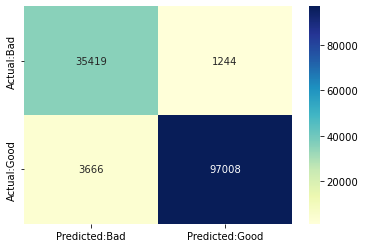

In [64]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### MultinomialNB

- NLP Problems Using Multinomial Naive Bayes. A series of probabilistic algorithms known as the Naive Bayes Classifier Algorithm is based on using the Bayes Theorem with the "naive" assumption that each pair of features is conditionally independent.

In [65]:
# create mnb object
mnb = MultinomialNB()

In [66]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [67]:
mnb.score(testX,testY)

0.9588603216904403

- MultinomialNB is giving us 95% accuracy  

In [68]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9739568795827276
Testing Accuracy : 0.9588603216904403

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.94      0.93     37903
        Good       0.98      0.97      0.97     99434

    accuracy                           0.96    137337
   macro avg       0.94      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


<AxesSubplot:>

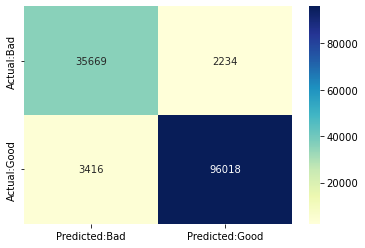

In [69]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

<AxesSubplot:ylabel='Accuracy'>

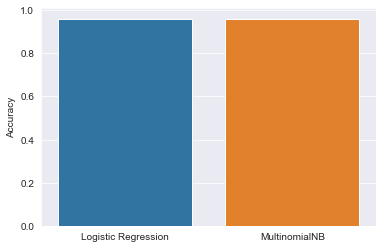

In [70]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

-  So, Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression

In [71]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = 
                                            RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
##(r'\b(?:http|ftp)s?://\S*\w|\w+|[^\w\s]+') ([a-zA-Z]+)([0-9]+)  -- these tolenizers giving me low accuray 

In [75]:
trainX, testX, trainY, testY = train_test_split(data_OG.URL, data_OG.Label)

In [76]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [78]:
pipeline_ls.score(testX,testY)

0.9656101414768052

Training Accuracy : 0.9794227795994748
Testing Accuracy : 0.9656101414768052

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36948
        Good       0.99      0.96      0.98    100389

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


<AxesSubplot:>

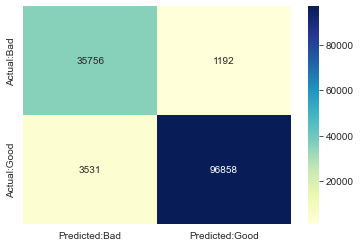

In [79]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [80]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [81]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9656101414768052


- I'm done now. See how easy it is yet how powerful it is. A 98% accuracy rate is obtained. That is a fairly high threshold at which a system may identify a bad URL. Want to test a few links to see if the model can accurately predict the future? Sure. Let's proceed.